# Proyecto 1 - Entrega 1
### Laura Carretero - 202214922
### Samuel Hernandez - 202213772
### Juan Rios - 202215787

## Sección 1 - Entendimiento del negocio y enfoque analítico

|  |  |
|-----------|-----------|
Oportunidad/problema Negocio  | Res 1   | |
Objetivos y criterios de éxito desde el punto de vista del negocio | Res 2   |
| Organización y rol dentro de ella que se beneficia con la oportunidad definida  | Res 3   |
| Impacto que puede tener en Colombia este proyecto | Res 4   |
| Enfoque analítico. Descripción de la categoría de análisis (descriptivo, predictivo, etc.) , tipo y tarea de aprendizaje e incluya las técnicas y algoritmos que propone utilizar | Res 5   |  |


## Sección 2 - Entendimiento y preparación de los datos

In [27]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
%pip install nltk
import nltk
from nltk.corpus import stopwords
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold 


In [28]:
# Leer el excel con los registros
r_ods = pd.read_excel('./data/ODScat_345.xlsx')

### 2.1 Perfilamiento de datos

In [29]:
r_ods.dtypes

Textos_espanol    object
sdg                int64
dtype: object

In [30]:
r_ods.sample(5)

,Textos_espanol,sdg
1011,Estas carencias son especialmente pronunciadas...,4
2584,Esto puede ser el resultado de diferentes pref...,5
3719,Estos deducibles se describen en las siguiente...,3
896,El VHI privado ha ido creciendo a lo largo de ...,3
869,"En Colombia, el Plan Obligatorio de Salud Subs...",3


Tenemos dos columnas. En Textos_espanol tenemos la opinion de un ciudadano. En sdg tenemos el ODS al cual se asocia ese texto, esta es una varible categorica

In [31]:
r_ods.shape

(4049, 2)

Tenemos 4049 registros

In [32]:
r_ods.describe()

,sdg
count,4049.000000
mean,4.051124
std,0.814338
min,3.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [33]:
r_ods['sdg'].value_counts()

sdg
5    1451
4    1354
3    1244
Name: count, dtype: int64

Puede estar asociado a los ODS 3, 4 o 5, que corresponden a: Salud y bienestar, educacion de calidad e igualdad de género, respectivamente.
La mayor cantidad de registros los tiene el ODS 5, sin embargo, los tres tienen una participacion aproximada al 33%

#### 2.1.1 Longitudes

Se revisaran las longitudes de los textos

In [34]:
longitudes = r_ods['Textos_espanol'].apply(len)

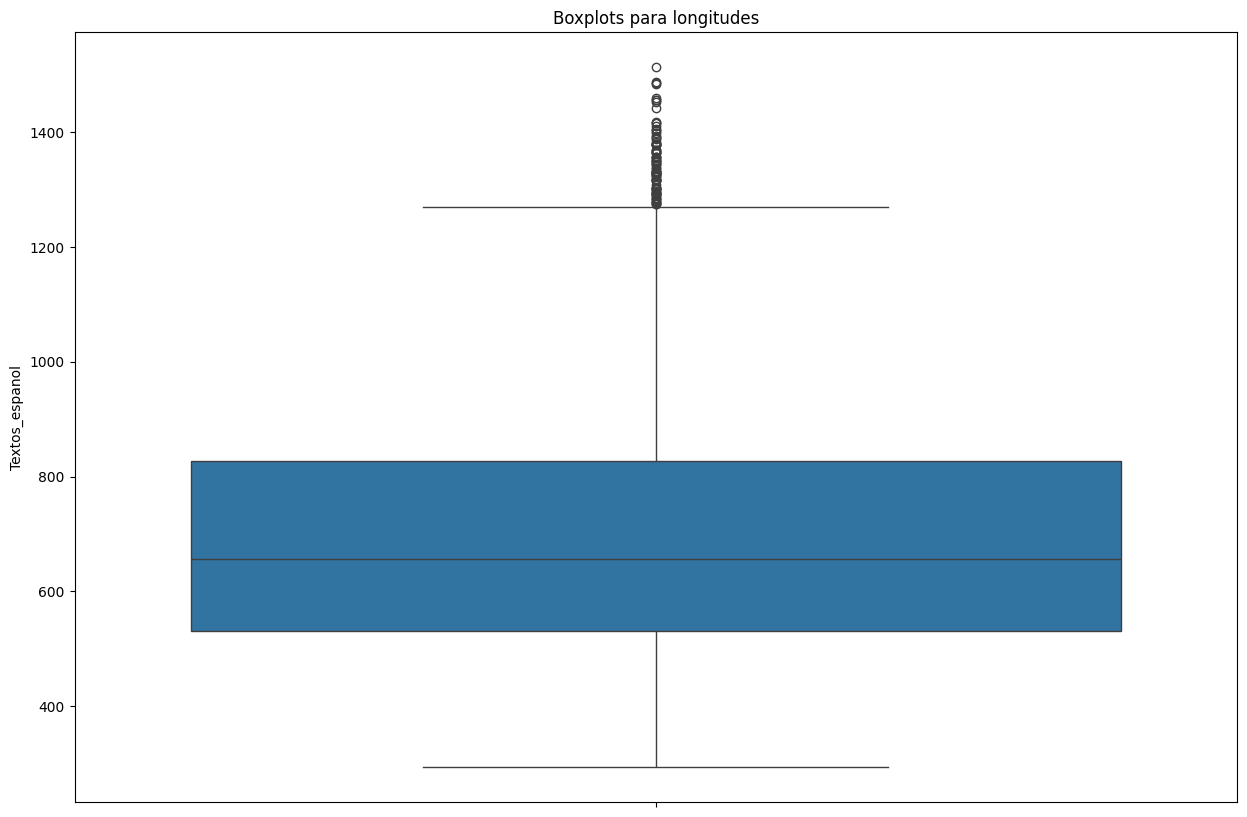

In [35]:
plt.figure(figsize=(15,10))
sns.boxplot(data=longitudes)
plt.title('Boxplots para longitudes')
plt.show()

Hay longitudes atipicas 

In [36]:
longitudes.describe()

count    4049.000000
mean      699.632502
std       228.988965
min       294.000000
25%       531.000000
50%       657.000000
75%       827.000000
max      1513.000000
Name: Textos_espanol, dtype: float64

La longitud mas corta es de 294 caracteres. La mas larga es de 1513. El promedio es de 700 caracteres

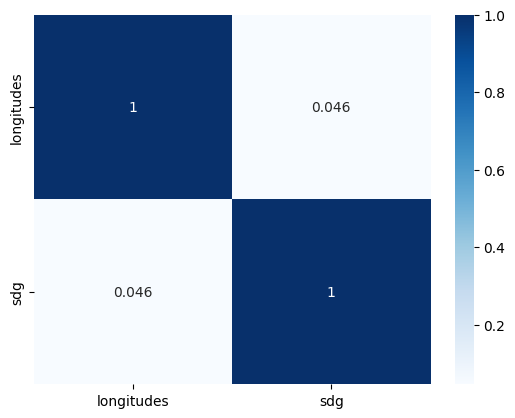

In [37]:
box_p = pd.DataFrame({'longitudes': longitudes, 'sdg': r_ods['sdg']}).corr()
sns.heatmap(box_p, cmap="Blues", annot=True)
plt.show()

Como se observa, la clasificacion del sdg y la longitus no tienen correlacion

### 2.2 Calidad de datos

#### 2.2.1 Completitud

In [38]:
r_ods.notnull().mean()*100

Textos_espanol    100.0
sdg               100.0
dtype: float64

Las dos columnas estan completas

#### 2.2.2 Unicidad

In [39]:
r_ods.duplicated(keep = False).sum()

0

No hay registros repetidos

#### 2.2.3 Consistencia

In [40]:
r_ods.dtypes

Textos_espanol    object
sdg                int64
dtype: object

El texto es un string, y el ODS es numerico. Es consistente

#### 2.2.4 Validez

Anteriormente se vio que sgd solo toma valores entre 3 y 5, lo cual es valido en el contexto que se trabaja

### 2.3 Preparación de datos

In [41]:
registros = r_ods.copy()

Se usara una funcion auxiliar para hacer la preparacion. Se va a pasar a minuscula el texto, y se eliminaran las palabras comunes del idioma español.
No se detectaron problemas en la calidad de los datos. Estan completos, son unicos, son consistentes y válidos

In [42]:
nltk.download('stopwords')

comunes = set(stopwords.words('spanish'))

def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(f'[{string.punctuation}]', '', texto)
    palabras = texto.split()
    palabras_limpias = [palabra for palabra in palabras if palabra not in comunes]
    return ' '.join(palabras_limpias)

registros['Textos_espanol_limpio'] = registros['Textos_espanol'].apply(limpiar_texto)
registros[['Textos_espanol', 'Textos_espanol_limpio']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\57313\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Textos_espanol,Textos_espanol_limpio
0,"Por ejemplo, el nÃºmero de consultas externas ...",ejemplo nãºmero consultas externas especialist...
1,"En 2007, el gobierno central financió directam...",2007 gobierno central financió directamente so...
2,"Claramente, hay muchos otros factores en juego...",claramente factores juego particular variedad ...
3,"Por ejemplo, el estado australiano de Victoria...",ejemplo australiano victoria creó agencia prom...
4,"El consumo anual de alcohol se estima en 15,7 ...",consumo anual alcohol estima 157 litros año ho...


## Sección 3 - Modelado y evaluación

In [43]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(registros['Textos_espanol_limpio'])

In [44]:
Y = registros['sdg']

In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

### Modelo 1: Decision Tree Classifier

In [46]:
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)
param_grid = {'criterion':['gini', 'entropy'],'max_depth':[4,6,8,10,20]}
arbol = DecisionTreeClassifier(random_state=0)

In [47]:
mejor_modelo = GridSearchCV(arbol, param_grid, cv=particiones)
# Ajuste del modelo
mejor_modelo.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10, 20]})

In [48]:
mejor_modelo.best_params_

{'criterion': 'entropy', 'max_depth': 20}

In [49]:
arbol = mejor_modelo.best_estimator_

In [50]:
y_pred = arbol.predict(X_test)

#### Métricas de evaluación

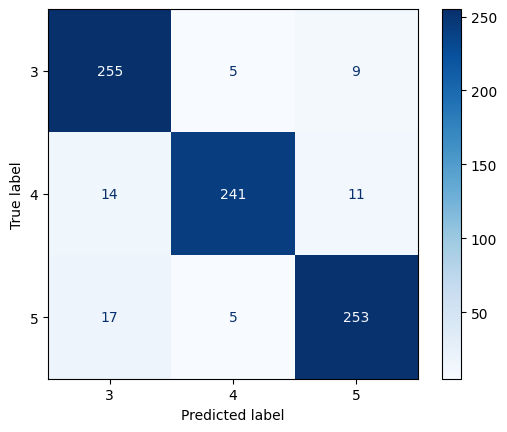

In [51]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_test, y_pred), display_labels=arbol.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [52]:
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred))
print("Recall: {}".format(recall_score(Y_test,y_pred,average='macro')))
print("Precisión: {}".format(precision_score(Y_test,y_pred,average='macro')))
print("Puntuación F1: {}".format(f1_score(Y_test,y_pred,average='macro')))

Exactitud: 0.92
Recall: 0.9246568093095191
Precisión: 0.9261692269660399
Puntuación F1: 0.9248594413216248


In [53]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           3       0.89      0.95      0.92       269
           4       0.96      0.91      0.93       266
           5       0.93      0.92      0.92       275

    accuracy                           0.92       810
   macro avg       0.93      0.92      0.92       810
weighted avg       0.93      0.92      0.92       810



### Modelo 2: Algoritmo

#### Métricas de evaluación

### Modelo 3: Algoritmo

#### Métricas de evaluación

## Sección 4 - Resultados

Se analiza las metrica

### Palabras clave

Vamos a ver las palabras que mas se repiten en cada ods

### Prediccion en el archivo

Se hara la prediccion sobre el test

## Sección 5 - Mapa de actores

| Rol dentro de la empresa | Tipo de actor | Beneficio | Riesgo |
|-----------|-----------|-----------|-----------|
| Coordinacion  | Usuario   | Apoya la labor  | Si el modelo no es bueno, entonces  |

## Sección 6 - Trabajo en equipo

- Laura Carretero
- Samuel Hernandez - Decision tree
- Juan Rios

### Puntos

- Laura Carretero
- Samuel Hernandez
- Juan Rios